In [ ]:
############### Comparison Step ##################

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls

gdrive/  sample_data/


In [2]:
cd gdrive/MyDrive/Dataset

/content/gdrive/MyDrive/Dataset


In [4]:
# hdvae
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # for a progress bar

# For Disentanglement Metrics
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import KBinsDiscretizer # for MIG discretization

# torch.autograd.set_detect_anomaly(True) # <--- ADD THIS LINE HERE

# If you are running on Colab and this solved the issue for you:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '0' # Reverted to asynchronous for faster execution
# If you want to keep debugging with synchronous errors uncomment the line below:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# --- DspritesDataset Class ---
class DspritesDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_path = os.path.join(root_dir, 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"dSprites data not found at {self.data_path}. "
                                    f"Please download it from https://github.com/deepmind/dsprites-dataset "
                                    f"and place it in the '{root_dir}' directory.")

        try:
            with np.load(self.data_path, encoding='bytes', allow_pickle=True) as data:
                self.imgs = data['imgs']
                self.latents_values = data['latents_values']
                self.latents_classes = data['latents_classes']
            print(f"Successfully loaded dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz from {self.data_path}")
            print(f"Number of images loaded: {len(self.imgs)}")
        except Exception as e:
            raise RuntimeError(f"Error loading dsprites.npz file: {e}. Please check if the file is corrupted or incomplete.")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image_np = self.imgs[idx]
        image = torch.from_numpy(image_np).float().unsqueeze(0)
        latents_value = torch.from_numpy(self.latents_values[idx]).float()
        latents_class = torch.from_numpy(self.latents_classes[idx]).long()

        if self.transform:
            image = self.transform(image)

        return image, latents_value, latents_class

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
image_size = 64 * 64
z1_dim = 64
z2_dim = 32
z3_dim = 16
num_epochs = 10
batch_size = 128
learning_rate = 1e-3


# dSprites dataset
dsprites_root_dir = './'
os.makedirs(dsprites_root_dir, exist_ok=True)

transform = None

full_dataset = DspritesDataset(root_dir=dsprites_root_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_loader_fixed_batch = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)
try:
    fixed_test_images, _, _ = next(iter(test_loader_fixed_batch))
    fixed_test_images = fixed_test_images.to(device)
except Exception as e:
    print(f"CRITICAL ERROR: Failed to load or move fixed test images to device: {e}")
    exit()

Successfully loaded dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz from ./dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz
Number of images loaded: 737280


In [25]:

# HDVAE Model
class HDVAE(nn.Module):
    def __init__(self, image_size, z1_dim, z2_dim, z3_dim):
        super(HDVAE, self).__init__()
        self.image_size = image_size
        self.z1_dim = z1_dim
        self.z2_dim = z2_dim
        self.z3_dim = z3_dim

        self.encoder_x_to_z1 = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_mu1 = nn.Linear(128, z1_dim)
        self.fc_logvar1 = nn.Linear(128, z1_dim)

        self.encoder_z1_to_z2 = nn.Sequential(
            nn.Linear(z1_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu2 = nn.Linear(64, z2_dim)
        self.fc_logvar2 = nn.Linear(64, z2_dim)

        self.encoder_z2_to_z3 = nn.Sequential(
            nn.Linear(z2_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu3 = nn.Linear(64, z3_dim)
        self.fc_logvar3 = nn.Linear(64, z3_dim)

        self.decoder_z3_to_z2_params = nn.Sequential(
            nn.Linear(z3_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc_prior_mu2 = nn.Linear(128, z2_dim)
        self.fc_prior_logvar2 = nn.Linear(128, z2_dim)

        self.decoder_z2_to_z1_params = nn.Sequential(
            nn.Linear(z2_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc_prior_mu1 = nn.Linear(128, z1_dim)
        self.fc_prior_logvar1 = nn.Linear(128, z1_dim)

        self.decoder_z1_to_x = nn.Sequential(
            nn.Linear(z1_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = self.encoder_x_to_z1(x.view(-1, self.image_size))
        mu1, log_var1 = self.fc_mu1(h1), self.fc_logvar1(h1)
        z1 = self.reparameterize(mu1, log_var1)

        h2 = self.encoder_z1_to_z2(z1)
        mu2, log_var2 = self.fc_mu2(h2), self.fc_logvar2(h2)
        z2 = self.reparameterize(mu2, log_var2)

        h3 = self.encoder_z2_to_z3(z2)
        mu3, log_var3 = self.fc_mu3(h3), self.fc_logvar3(h3)
        z3 = self.reparameterize(mu3, log_var3)

        return (mu1, log_var1, z1), (mu2, log_var2, z2), (mu3, log_var3, z3)

    def decode(self, z1, z2, z3):
        x_reconst = self.decoder_z1_to_x(z1)

        h_prior_z1 = self.decoder_z2_to_z1_params(z2)
        mu_prior_1 = self.fc_prior_mu1(h_prior_z1)
        log_var_prior_1 = self.fc_prior_logvar1(h_prior_z1)

        h_prior_z2 = self.decoder_z3_to_z2_params(z3)
        mu_prior_2 = self.fc_prior_mu2(h_prior_z2)
        log_var_prior_2 = self.fc_prior_logvar2(h_prior_z2)

        return x_reconst, (mu_prior_1, log_var_prior_1), (mu_prior_2, log_var_prior_2)

    def forward(self, x):
        (mu1, log_var1, z1), (mu2, log_var2, z2), (mu3, log_var3, z3) = self.encode(x)
        x_reconst, (mu_prior_1, log_var_prior_1), (mu_prior_2, log_var_prior_2) = self.decode(z1, z2, z3)

        return x_reconst, mu1, log_var1, z1, mu2, log_var2, z2, mu3, log_var3, z3, \
               mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2

# Instantiate the model
print(f"Attempting to move model to device: {device}")

model = HDVAE(image_size, z1_dim, z2_dim, z3_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print(model)

# Loss Function
def loss_function_hdvae(recon_x, x, mu1, log_var1, mu2, log_var2, mu3, log_var3, mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2,
                        beta1=1.0, beta2=1.0, beta3=1.0):

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size), reduction='sum')

    KLD_z3 = -0.5 * torch.sum(1 + log_var3 - mu3.pow(2) - log_var3.exp())

    log_var_prior_2_clamped = torch.clamp(log_var_prior_2, min=-20.0, max=20.0)
    log_var2_clamped = torch.clamp(log_var2, min=-20.0, max=20.0)
    KLD_z2 = 0.5 * torch.sum(
        torch.exp(log_var2_clamped - log_var_prior_2_clamped) +
        ((mu_prior_2 - mu2)**2) * torch.exp(-log_var_prior_2_clamped) - 1 +
        (log_var_prior_2_clamped - log_var2_clamped)
    )

    log_var_prior_1_clamped = torch.clamp(log_var_prior_1, min=-20.0, max=20.0)
    log_var1_clamped = torch.clamp(log_var1, min=-20.0, max=20.0)
    KLD_z1 = 0.5 * torch.sum(
        torch.exp(log_var1_clamped - log_var_prior_1_clamped) +
        ((mu_prior_1 - mu1)**2) * torch.exp(-log_var_prior_1_clamped) - 1 +
        (log_var_prior_1_clamped - log_var1_clamped)
    )

    return BCE + beta1 * KLD_z1 + beta2 * KLD_z2 + beta3 * KLD_z3


hdvae_loss_history = []


print("Starting HDVAE training with 3 hierarchical layers on dSprites...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (images, _, _) in enumerate(train_loader):
        images = images.to(device)

        recon_images, mu1, log_var1, z1, mu2, log_var2, z2, mu3, log_var3, z3, \
               mu_prior_1, log_var_prior_1, mu_prior_2, log_var_prior_2 = model(images)


        ### MRH:
        ################ linear annealing for Beta  in loss function:
        num_annealing_epochs = num_epochs / 2
        beta_anneelling_factor = min(1.0, epoch / num_annealing_epochs)
        # --- REDUCED MAX BETA VALUES FOR STABILITY ---
        max_beta1 = 5 #4 > 3.3 #5 > 4 #3 => 2.4
        max_beta2 = 4   #3      #4      #2
        max_beta3 = 3   #1      #2      #1
        current_beta1 = beta_anneelling_factor * max_beta1
        current_beta2 = beta_anneelling_factor * max_beta2
        current_beta3 = beta_anneelling_factor * max_beta3
        ################

        loss = loss_function_hdvae(recon_images, images,
                                   mu1, log_var1,
                                   mu2, log_var2,
                                   mu3, log_var3,
                                   mu_prior_1, log_var_prior_1,
                                   mu_prior_2, log_var_prior_2, beta1=current_beta1, beta2=current_beta2, beta3=current_beta3)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Avg Loss: {avg_loss:.4f}")
    hdvae_loss_history.append(avg_loss)

print("Training complete!")


################################
model_HDVAE = model


Attempting to move model to device: cuda
Starting HDVAE training with 3 hierarchical layers on dSprites...
Epoch [1/10], Step [100/4608], Loss: 70787.1875
Epoch [1/10], Step [200/4608], Loss: 15593.1953
Epoch [1/10], Step [300/4608], Loss: 14995.1201
Epoch [1/10], Step [400/4608], Loss: 14449.4531
Epoch [1/10], Step [500/4608], Loss: 13626.4844
Epoch [1/10], Step [600/4608], Loss: 15027.2070
Epoch [1/10], Step [700/4608], Loss: 14216.0439
Epoch [1/10], Step [800/4608], Loss: 12968.4668
Epoch [1/10], Step [900/4608], Loss: 12853.1230
Epoch [1/10], Step [1000/4608], Loss: 13335.6562
Epoch [1/10], Step [1100/4608], Loss: 12945.8730
Epoch [1/10], Step [1200/4608], Loss: 13713.0430
Epoch [1/10], Step [1300/4608], Loss: 12814.6211
Epoch [1/10], Step [1400/4608], Loss: 11443.4121
Epoch [1/10], Step [1500/4608], Loss: 11852.7344
Epoch [1/10], Step [1600/4608], Loss: 11543.0449
Epoch [1/10], Step [1700/4608], Loss: 10910.0381
Epoch [1/10], Step [1800/4608], Loss: 10407.2373
Epoch [1/10], Step [

In [6]:

# --- Quantitative Metrics (Disentanglement) ---

# Updated collect_latent_factors_for_metrics function
# Assuming KBinsDiscretizer is imported if not already.
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np # Ensure numpy is imported
import torch # Ensure torch is imported
from tqdm.auto import tqdm # Ensure tqdm is imported

def collect_latent_factors_for_metrics(model, data_loader, device, num_samples_to_collect=None):
    model.eval()
    all_mu1 = []
    all_latents_values = [] # This will store the continuous ground truth factors

    # dSprites factor names (excluding 'color')
    factor_names = ["color", "shape", "scale", "orientation", "posX", "posY"]
    active_factors_idx = [1, 2, 3, 4, 5] # Exclude color (index 0)

    print(f"Collecting latent representations and ground truth factors for metrics (up to {num_samples_to_collect if num_samples_to_collect else 'all'} samples)...")
    samples_collected = 0
    with torch.no_grad():
        # --- MODIFIED LINE HERE (same as before) ---
        # Assuming your DataLoader yields (image, latents_values, latents_classes)
        for batch_idx, (images, latents_values_batch, latents_classes_batch) in tqdm(enumerate(data_loader), desc="Collecting data for metrics"):
            images = images.to(device)
            # print('mrh= ',images.shape)
            # raise Exception(" MRH ")

            # Extract ground truth factors (continuous values)
            # For dSprites, latents_values_batch tensor structure is usually:
            # latents_values_batch[:, 0] = color (constant)
            # latents_values_batch[:, 1] = shape
            # latents_values_batch[:, 2] = scale
            # latents_values_batch[:, 3] = orientation
            # latents_values_batch[:, 4] = posX
            # latents_values_batch[:, 5] = posY
            # --- CORRECTED LINE BELOW ---
            ground_truth_factors = latents_values_batch.cpu().numpy() # Use the correct variable name

            # Encode the image to get latent means (mu1)
            (_, _, z1_mu), (_, _, z2_mu), (_, _, z3_mu) = model.encode(images)

            # print('z1_mu shape = ',z1_mu.shape)
            # raise Exception(" MRH ")

            all_mu1.append(z1_mu.cpu().numpy())
            all_latents_values.append(ground_truth_factors)

            samples_collected += images.size(0)
            if num_samples_to_collect is not None and samples_collected >= num_samples_to_collect:
                break # Stop collecting once enough samples are gathered

    mu1_for_metrics = np.concatenate(all_mu1, axis=0)
    latents_values_for_metrics = np.concatenate(all_latents_values, axis=0)

    # Ensure we only return up to num_samples_to_collect if specified
    if num_samples_to_collect is not None:
        mu1_for_metrics = mu1_for_metrics[:num_samples_to_collect]
        latents_values_for_metrics = latents_values_for_metrics[:num_samples_to_collect]
        print(f"Collected {mu1_for_metrics.shape[0]} samples for metrics.")

    return mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx
#######################################################
# Function to calculate MIG (Mutual Information Gap)
# Add this import at the top of your script alongside other imports
from joblib import Parallel, delayed

# --- Updated calculate_mig function ---
def calculate_mig(mus, latents_values, factor_names, active_factors_idx,
                  num_bins_for_mi=20): # Added num_bins_for_mi as an argument
    print("\nCalculating MIG (Mutual Information Gap) Score...")

    num_latents = mus.shape[1]
    num_active_factors = len(active_factors_idx)

    # Discretize continuous factors for MI calculation if they are continuous
    # And discretize the latent dimensions
    discretized_mus = np.zeros_like(mus, dtype=int)
    discretized_latents_values = np.zeros_like(latents_values, dtype=int)

    # Discretize latent dimensions (mus)
    print(f"Discretizing latent dimensions into {num_bins_for_mi} bins for MI calculation...")
    for i in tqdm(range(num_latents), desc="Discretizing Latents"):
        latent_data = mus[:, i].reshape(-1, 1)
        # Using KBinsDiscretizer with 'uniform' or 'quantile' can be robust
        discretizer = KBinsDiscretizer(n_bins=num_bins_for_mi, encode='ordinal', strategy='uniform') # 'uniform' or 'quantile'
        discretized_mus[:, i] = discretizer.fit_transform(latent_data).flatten().astype(int)

    # Discretize active ground truth factors
    print(f"Discretizing ground truth factors into {num_bins_for_mi} bins for MI calculation...")
    for j in tqdm(active_factors_idx, desc="Discretizing Factors"):
        factor_data = latents_values[:, j].reshape(-1, 1)
        discretizer = KBinsDiscretizer(n_bins=num_bins_for_mi, encode='ordinal', strategy='uniform') # 'uniform' or 'quantile'
        discretized_latents_values[:, j] = discretizer.fit_transform(factor_data).flatten().astype(int)

    # Calculate mutual information for all pairs (latent_dim, factor)
    mi_matrix = np.zeros((num_latents, num_active_factors))

    print("Calculating MI matrix (this can take a while)...")
    # --- Parallelize the MI calculation loop ---
    # n_jobs=-1 means use all available CPU cores
    # backend='threading' can be faster for numpy/scipy operations
    results = Parallel(n_jobs=-1, verbose=0, backend='threading')(
        delayed(mutual_info_score)(discretized_mus[:, i], discretized_latents_values[:, factor_idx_in_full])
        for i in range(num_latents)
        for factor_idx_in_full in active_factors_idx
    )

    # Populate mi_matrix from results
    k = 0
    for i in range(num_latents):
        for j_idx, factor_idx_in_full in enumerate(active_factors_idx):
            mi_matrix[i, j_idx] = results[k]
            k += 1


    # Calculate MIG score
    mig_scores = []
    for j in range(num_active_factors): # Iterate over ground truth factors
        # Get MI values for the current factor across all latent dimensions
        mi_values_for_factor = mi_matrix[:, j]
        # Sort them in descending order
        sorted_mi = np.sort(mi_values_for_factor)[::-1]

        # Calculate MIG: (MI_1st_most_informative - MI_2nd_most_informative) / MI_1st_most_informative
        if len(sorted_mi) >= 2 and sorted_mi[0] > 0: # Ensure there are at least two values and the max MI is not zero
            mig = (sorted_mi[0] - sorted_mi[1]) / sorted_mi[0]
            mig_scores.append(mig)
        else:
            mig_scores.append(0.0) # Cannot calculate MIG if less than 2 latent dimensions or max MI is zero

    avg_mig_score = np.mean(mig_scores) if mig_scores else 0.0

    report_lines = [
        "\nMIG Score:",
        "--------------------------------------------------",
        f"  Average MIG Score: {avg_mig_score:.4f}",
        "--------------------------------------------------"
    ]
    print("\n".join(report_lines))

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(num_active_factors * 0.8 + 2, num_latents * 0.5 + 2))
    cax = ax.imshow(mi_matrix, cmap='magma', aspect='auto') # 'magma' or 'viridis' are good for heatmaps
    fig.colorbar(cax, label='Mutual Information')

    ax.set_xticks(np.arange(num_active_factors))
    ax.set_yticks(np.arange(num_latents))

    # Map active_factors_idx back to their original names for labels
    active_factor_names_mapped = [factor_names[idx] for idx in active_factors_idx]
    ax.set_xticklabels(active_factor_names_mapped, rotation=45, ha="right")
    ax.set_yticklabels([f"z{i+1}" for i in range(num_latents)])

    ax.set_xlabel("Ground Truth Factor")
    ax.set_ylabel("Latent Dimension")
    ax.set_title("Mutual Information Heatmap (Latents vs. Factors)")
    fig.tight_layout()
    plt.savefig("mig_mi_heatmap.png")
    plt.close(fig)

    print("Mutual Information Heatmap saved to mig_mi_heatmap.png")

    return avg_mig_score, report_lines

##########################################################
# Function to calculate Linear Regression Disentanglement Score (Simplified Beta-VAE style)
def calculate_linear_disentanglement_score(mus, latents_values, factor_names, active_factors_idx):
    print("\nCalculating Linear Regression Disentanglement Score (R-squared)...")
    num_latents = mus.shape[1]
    num_factors = latents_values.shape[1]

    r2_matrix = np.zeros((num_latents, num_factors))
    p_values_matrix = np.zeros((num_latents, num_factors)) # Not used directly in score, but informative

    results_str = ["\nLinear Regression R-squared Scores:"]
    results_str.append("--------------------------------------------------")
    results_str.append(f"{'Latent Dim':<12} | {' '.join([f'{f:<10}' for f in [factor_names[idx] for idx in active_factors_idx]])}")
    results_str.append("-" * (12 + 3 + len(active_factors_idx) * 11))

    for i in tqdm(range(num_latents), desc="Fitting linear regressors"):
        row_r2_values = []
        for j in active_factors_idx: # Iterate only over active factors
            regressor = LinearRegression()
            regressor.fit(mus[:, i:i+1], latents_values[:, j]) # Predict factor from single latent dim
            r2 = r2_score(latents_values[:, j], regressor.predict(mus[:, i:i+1]))
            r2_matrix[i, j] = r2 if not np.isnan(r2) else 0.0 # Handle NaN if regression fails (e.g., constant latent dim)
            row_r2_values.append(f'{r2_matrix[i, j]:<10.4f}')
        results_str.append(f"{f'Latent {i}':<12} | {' '.join(row_r2_values)}")

    # Calculate disentanglement score:
    # For each ground truth factor, find the latent dimension that explains it best (highest R2).
    # The score is often defined as the average of the maximum R2 for each factor.
    # Alternatively, for *disentanglement*, you look for high R2 for one factor, low for others.
    # A common beta-VAE style score is: for each factor, find the latent dimension with max R2,
    # then average these max R2s.
    factor_disentanglement_scores = []
    disentanglement_summary = ["\nDisentanglement Summary (Per Ground Truth Factor):"]
    disentanglement_summary.append("--------------------------------------------------")

    for j in active_factors_idx:
        max_r2_for_factor = -1.0
        best_latent_dim = -1
        for i in range(num_latents):
            if r2_matrix[i, j] > max_r2_for_factor:
                max_r2_for_factor = r2_matrix[i, j]
                best_latent_dim = i
        factor_disentanglement_scores.append(max_r2_for_factor)
        disentanglement_summary.append(f"  {factor_names[j]}: Best explained by Latent {best_latent_dim} (R2: {max_r2_for_factor:.4f})")

    avg_disentanglement_score = np.mean(factor_disentanglement_scores) if factor_disentanglement_scores else 0.0
    disentanglement_summary.append("--------------------------------------------------")
    disentanglement_summary.append(f"Average Disentanglement Score (Max R2 per factor): {avg_disentanglement_score:.4f}")

    print("\n".join(results_str))
    print("\n".join(disentanglement_summary))

    # Optional: Save R2 matrix to a file
    np.save(os.path.join('./metrics_hdvae', 'linear_r2_matrix.npy'), r2_matrix)
    print(f"Saved R2 matrix to {os.path.join('./metrics_hdvae', 'linear_r2_matrix.npy')}")

    # Optional: Save and plot R2 matrix as a heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(r2_matrix[:, active_factors_idx].T, cmap='magma', aspect='auto', vmin=0, vmax=1) # Transposed
    plt.colorbar(label='R-squared Score')
    plt.xlabel('Latent Dimensions (z1)')
    plt.ylabel('Ground Truth Factors')
    plt.title('R-squared (R2) between Latent Dimensions and Ground Truth Factors')
    plt.xticks(np.arange(num_latents), labels=[f'z{i}' for i in range(num_latents)], rotation=90)
    plt.yticks(np.arange(len(active_factors_idx)), labels=[factor_names[i] for i in active_factors_idx])
    plt.tight_layout()
    plt.savefig(os.path.join('./metrics_hdvae', 'linear_r2_heatmap.png'))
    plt.show()
    print(f"Saved R2 heatmap to {os.path.join('./metrics_hdvae', 'linear_r2_heatmap.png')}")

    return avg_disentanglement_score, results_str, disentanglement_summary
########################
# Updated calculate_dci function
from sklearn.ensemble import RandomForestClassifier # For informativeness, disentanglement, completeness
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mutual_info_score, f1_score
from sklearn.preprocessing import KBinsDiscretizer # Ensure this is imported for discretization

def calculate_dci(mus, latents_values, factor_names, active_factors_idx,
                  test_size=0.2, random_state=42):
    print("\nCalculating DCI (Disentanglement, Completeness, Informativeness) Score...")

    # We'll use the provided mus and latents_values.
    # Note: For dSprites' continuous factors, we need to adapt the classification approach.
    # A common approach is to discretize the factors or use a regressor.
    # For a general DCI implementation that aims for "classification accuracy" like behavior,
    # we can discretize the factors. However, the original DCI paper often uses
    # regressors or assumes discrete factors.
    # Let's adapt for continuous factors by treating them as regression tasks
    # and using RandomForestRegressor, then assessing "informativeness" as R2.
    # For disentanglement/completeness, we'll still use a classifier,
    # meaning we'll discretize the ground truth factors.

    # Discretize continuous ground truth factors for DCI classification component
    # This is a critical step for dSprites as its factors are continuous.
    # You can adjust num_bins as needed. Higher bins means more granular factors.
    num_bins_for_factors = 10 # For shape, scale, orientation, posX, posY
    discretized_latents_values = np.zeros_like(latents_values, dtype=int)
    factor_discretizers = {}

    print(f"Discretizing ground truth factors into {num_bins_for_factors} bins for DCI...")
    for j in active_factors_idx:
        factor_data = latents_values[:, j].reshape(-1, 1)
        # Use KBinsDiscretizer to discretize each continuous factor
        # 'quantile' strategy works well for non-uniform distributions
        discretizer = KBinsDiscretizer(n_bins=num_bins_for_factors, encode='ordinal', strategy='quantile')
        discretized_latents_values[:, j] = discretizer.fit_transform(factor_data).flatten().astype(int)
        factor_discretizers[j] = discretizer # Store if needed for inverse transform or checking bins

    # Filter to only active factors for X and y for classification
    mus_active = mus
    discretized_latents_active = discretized_latents_values[:, active_factors_idx]

    num_latents = mus_active.shape[1]
    num_active_factors = len(active_factors_idx)

    # Initialize results
    informativeness_scores = []
    disentanglement_scores = np.zeros((num_active_factors, num_latents))
    completeness_scores = np.zeros((num_active_factors, num_latents))

    # Split data into training and test sets for the classifiers
    X_train, X_test, y_train_factors, y_test_factors = train_test_split(
        mus_active, discretized_latents_active, test_size=test_size, random_state=random_state
    )

    print("Training RandomForestClassifiers for each ground truth factor...")
    # 1. Informativeness, Disentanglement, Completeness Calculation
    # For each ground truth factor, train a classifier to predict it from the latent representation
    # and assess how much each latent dimension contributes.
    for i in tqdm(range(num_active_factors), desc="DCI per factor"):
        factor_idx_in_full = active_factors_idx[i]
        y_train_factor = y_train_factors[:, i]
        y_test_factor = y_test_factors[:, i]

        # Classifier for the i-th ground truth factor
        # Adjust max_depth, n_estimators as needed. Lower max_depth for simpler models.
        # Ensure we have enough samples per class if some bins are sparse
        min_samples_leaf = 5 # Avoid overfitting by requiring more samples per leaf
        if len(np.unique(y_train_factor)) > 1: # Ensure there's more than one class
            classifier = RandomForestClassifier(n_estimators=100, random_state=random_state,
                                                min_samples_leaf=min_samples_leaf)
            classifier.fit(X_train, y_train_factor)

            # Informativeness (Accuracy on test set)
            y_pred = classifier.predict(X_test)
            informativeness = accuracy_score(y_test_factor, y_pred)
            informativeness_scores.append(informativeness)

            # Feature importance for disentanglement and completeness
            # Normalized feature importances from the RandomForestClassifier
            importance_scores = classifier.feature_importances_

            # Disentanglement: for each ground truth factor, how concentrated is its
            # importance on a single latent dimension?
            # Higher importance for one dimension, lower for others.
            if np.sum(importance_scores) > 0:
                disentanglement_scores[i, :] = importance_scores / np.sum(importance_scores)
            else:
                disentanglement_scores[i, :] = 0

            # Completeness: (Calculated from importance scores of the same classifier)
            # This is handled in the final calculation, but it's about how many latent
            # dimensions are important for a single factor.
        else: # Factor has only one unique value in training, cannot train classifier
            informativeness_scores.append(0)
            disentanglement_scores[i, :] = 0


    # DCI Score Calculations
    # ---------------------

    # Informativeness: Average informativeness (accuracy) across all factors
    mean_informativeness = np.mean(informativeness_scores)

    # Disentanglement: For each ground truth factor f,
    # find its importance distribution over latent dimensions.
    # The score is 1 - (sum of entropies of these distributions).
    # If all importance is concentrated on one latent dimension (low entropy), score is high.
    disentanglement = 0.0
    for i in range(num_active_factors): # For each ground truth factor
        if np.sum(disentanglement_scores[i, :]) > 0:
            # Normalize to sum to 1 to treat as probability distribution for entropy
            p_i = disentanglement_scores[i, :] / np.sum(disentanglement_scores[i, :])
            # Use negative sum(p*log(p)) for entropy. Add small epsilon for log(0)
            entropy_i = -np.sum(p_i * np.log(p_i + 1e-10))
            # Max possible entropy is log(num_latents) for uniform distribution
            max_entropy = np.log(num_latents + 1e-10) # Add epsilon to avoid log(0) if num_latents is 0
            if max_entropy > 0:
                disentanglement += (1 - entropy_i / max_entropy)
            else:
                disentanglement += 1.0 # If only one latent dim, it's perfectly disentangled by default
    mean_disentanglement = disentanglement / num_active_factors if num_active_factors > 0 else 0.0


    # Completeness: For each latent dimension z,
    # find its importance distribution over ground truth factors.
    # The score is 1 - (sum of entropies of these distributions).
    # If a latent dimension is important for only one factor (low entropy), score is high.
    completeness = 0.0
    # Transpose disentanglement_scores to get (latent_dim, factor_idx)
    # This is effectively the importance of latent_dim for factor_idx
    completeness_importance_matrix = disentanglement_scores.T # (num_latents, num_active_factors)

    for j in range(num_latents): # For each latent dimension
        if np.sum(completeness_importance_matrix[j, :]) > 0:
            # Normalize to sum to 1 to treat as probability distribution for entropy
            p_j = completeness_importance_matrix[j, :] / np.sum(completeness_importance_matrix[j, :])
            entropy_j = -np.sum(p_j * np.log(p_j + 1e-10))
            max_entropy = np.log(num_active_factors + 1e-10) # Max possible entropy for uniform distribution over factors
            if max_entropy > 0:
                completeness += (1 - entropy_j / max_entropy)
            else:
                completeness += 1.0 # If only one active factor, it's perfectly complete by default
    mean_completeness = completeness / num_latents if num_latents > 0 else 0.0


    results_str = [
        "\nDCI Scores:",
        "--------------------------------------------------",
        f"  Informativeness: {mean_informativeness:.4f}",
        f"  Disentanglement: {mean_disentanglement:.4f}",
        f"  Completeness:    {mean_completeness:.4f}",
        "--------------------------------------------------"
    ]
    print("\n".join(results_str))

    return mean_informativeness, mean_disentanglement, mean_completeness, results_str



##########



Starting Quantitative Metrics Evaluation



Collected 20000 samples for metrics.

Calculating MIG (Mutual Information Gap) Score...
Discretizing latent dimensions into 20 bins for MI calculation...


Discretizing Latents:   0%|          | 0/64 [00:00<?, ?it/s]

Discretizing ground truth factors into 20 bins for MI calculation...


Discretizing Factors:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating MI matrix (this can take a while)...

MIG Score:
--------------------------------------------------
  Average MIG Score: 0.6521
--------------------------------------------------
Mutual Information Heatmap saved to mig_mi_heatmap.png

Calculating Linear Regression Disentanglement Score (R-squared)...


Fitting linear regressors:   0%|          | 0/64 [00:00<?, ?it/s]


Linear Regression R-squared Scores:
--------------------------------------------------
Latent Dim   | shape      scale      orientation posX       posY      
----------------------------------------------------------------------
Latent 0     | 0.0000     0.0002     0.0002     0.0001     0.0001    
Latent 1     | 0.0000     0.0000     0.0000     0.0011     0.0000    
Latent 2     | 0.0000     0.0001     0.0001     0.0004     0.0001    
Latent 3     | 0.1344     0.6473     0.0001     0.0015     0.0064    
Latent 4     | 0.0001     0.0000     0.0000     0.0010     0.0002    
Latent 5     | 0.0000     0.0000     0.0000     0.0007     0.0000    
Latent 6     | 0.0000     0.0000     0.0000     0.0006     0.0001    
Latent 7     | 0.0001     0.0000     0.0000     0.0018     0.0027    
Latent 8     | 0.0000     0.0000     0.0000     0.0001     0.0000    
Latent 9     | 0.0001     0.0022     0.0000     0.0199     0.8720    
Latent 10    | 0.0000     0.0000     0.0000     0.0010     0.0013    


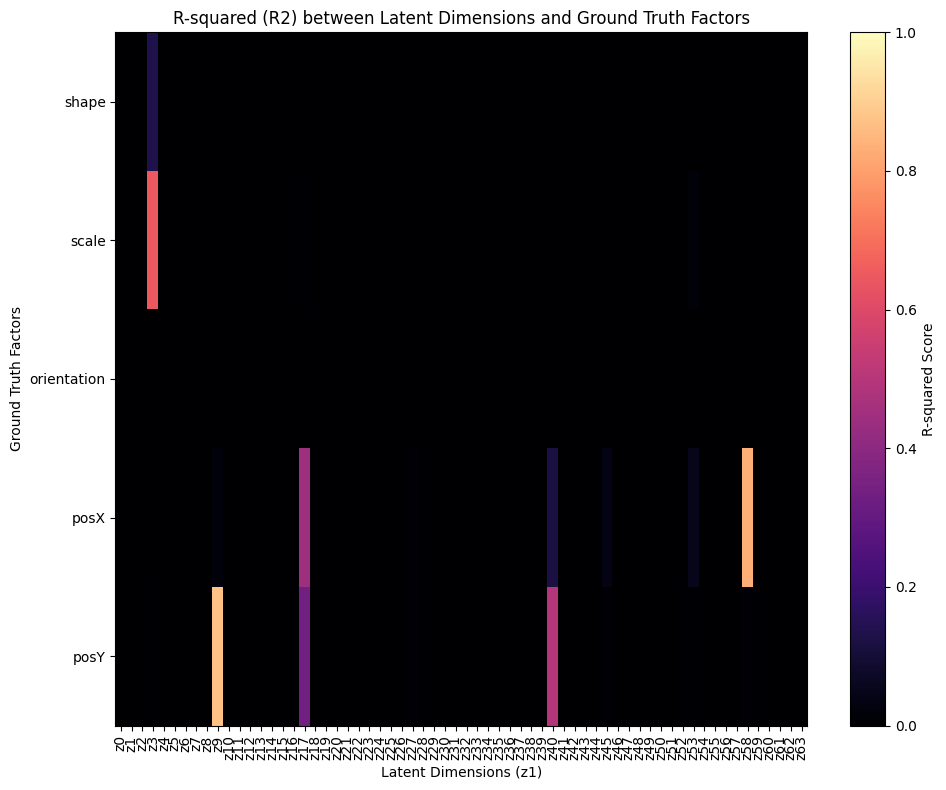

Saved R2 heatmap to ./metrics_hdvae/linear_r2_heatmap.png

Calculating DCI (Disentanglement, Completeness, Informativeness) Score...
Discretizing ground truth factors into 10 bins for DCI...
Training RandomForestClassifiers for each ground truth factor...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


DCI per factor:   0%|          | 0/5 [00:00<?, ?it/s]


DCI Scores:
--------------------------------------------------
  Informativeness: 0.6142
  Disentanglement: 0.1555
  Completeness:    0.0610
--------------------------------------------------

Quantitative Metrics Evaluation Complete



In [26]:
# HDVAE
# --- Run Metrics After Training ---
print("\n" + "="*50)
print("Starting Quantitative Metrics Evaluation")
print("="*50 + "\n")

# Define the number of samples for metrics calculation to speed it up.
# For dSprites, 10,000 to 20,000 samples is usually sufficient.
# Set to None to use all available samples in the test_dataset.
NUM_SAMPLES_FOR_METRICS = 20000

# Collect data for metrics (using test_loader, but now limited by NUM_SAMPLES_FOR_METRICS)
# It's good to keep batch_size for the data_loader relatively high (e.g., 256)
# to make efficient use of the GPU during the forward pass.
metrics_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)


######################################
# model=model_HDVAE

mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx = \
    collect_latent_factors_for_metrics(model, metrics_data_loader, device,
                                       num_samples_to_collect=NUM_SAMPLES_FOR_METRICS)

# Calculate and print MIG
mig_avg_score, mig_report = calculate_mig(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print Linear Regression Disentanglement Score
linear_disentanglement_avg_score, linear_r2_report, linear_disentanglement_summary = \
    calculate_linear_disentanglement_score(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print DCI
dci_informativeness, dci_disentanglement, dci_completeness, dci_report = \
    calculate_dci(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

print("\n" + "="*50)
print("Quantitative Metrics Evaluation Complete")
print("="*50 + "\n")


In [27]:
all_model_results = []
model_name = "HDVAE"
model_results = {
    "Model": model_name,
    "MIG Score": mig_avg_score,
    "DCI Informativeness": dci_informativeness,
    "DCI Disentanglement": dci_disentanglement,
    "DCI Completeness": dci_completeness,
    "Average R2 Disentanglement": linear_disentanglement_avg_score,
}
all_model_results.append(model_results)
print(f"Finished evaluating {model_name}.")

Finished evaluating HDVAE.


In [22]:
#
# V4: Beta-VAE for comparison
class BetaVAE(nn.Module):
    def __init__(self, image_size, z_dim):
        super(BetaVAE, self).__init__()
        self.image_size = image_size
        self.z_dim = z_dim

        # Encoder (identical to Vanilla VAE and HDVAE's encoder_x_to_z1 part)
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_mu = nn.Linear(128, z_dim)
        self.fc_logvar = nn.Linear(128, z_dim)

        # Decoder (identical to Vanilla VAE and HDVAE's decoder_z1_to_x part)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x.view(-1, self.image_size))
        # print('mrh x= ',x.shape)
        # print('mrh x= ',x.view(-1, self.image_size).shape)
        # print('mrh= ',h.shape)
        # raise Exception(" MRH ")
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        z = self.reparameterize(mu, log_var)

        # Decode
        recon_x = self.decoder(z)
        return recon_x, mu, log_var


# --- Loss Function for Vanilla VAE ---
def loss_function_beta_vae(recon_x, x, mu, log_var, beta): # beta is now a required argument
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + beta * KLD



beta_vae_z_dim = z1_dim # Still 64

# Choose a beta value. Common values are 4 or 8 to encourage disentanglement.
# Let's start with 4.0. You can experiment with this.
beta_vae_beta_value = 4.0

beta_vae_model_ = BetaVAE(image_size, beta_vae_z_dim).to(device)
beta_vae_optimizer = torch.optim.Adam(beta_vae_model_.parameters(), lr=learning_rate)

#print("\n--- Beta-VAE Model ---")
#print(beta_vae_model)

# --- Training Loop for Beta-VAE ---
print(f"\nStarting Beta-VAE training with beta = {beta_vae_beta_value}...")
for epoch in range(num_epochs): # Using the same num_epochs as HDVAE for direct comparison
    beta_vae_model_.train()
    total_loss = 0
    for i, (images, _,_) in enumerate(train_loader):
        images = images.to(device)

        recon_images, mu, log_var = beta_vae_model_(images)

        # Here we pass the fixed beta_vae_beta_value
        loss = loss_function_beta_vae(recon_images, images, mu, log_var, beta=beta_vae_beta_value)

        beta_vae_optimizer.zero_grad()
        loss.backward()
        beta_vae_optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Beta-VAE - Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Beta-VAE - Epoch [{epoch+1}/{num_epochs}]")

print("Training complete!")



Starting Beta-VAE training with beta = 4.0...
Beta-VAE - Epoch [1/10], Step [100/4608], Loss: 67680.7969
Beta-VAE - Epoch [1/10], Step [200/4608], Loss: 44103.9688
Beta-VAE - Epoch [1/10], Step [300/4608], Loss: 33172.7266
Beta-VAE - Epoch [1/10], Step [400/4608], Loss: 27396.4375
Beta-VAE - Epoch [1/10], Step [500/4608], Loss: 25057.2422
Beta-VAE - Epoch [1/10], Step [600/4608], Loss: 23431.9922
Beta-VAE - Epoch [1/10], Step [700/4608], Loss: 22335.2129
Beta-VAE - Epoch [1/10], Step [800/4608], Loss: 21104.1074
Beta-VAE - Epoch [1/10], Step [900/4608], Loss: 21087.2422
Beta-VAE - Epoch [1/10], Step [1000/4608], Loss: 21205.2578
Beta-VAE - Epoch [1/10], Step [1100/4608], Loss: 20842.1016
Beta-VAE - Epoch [1/10], Step [1200/4608], Loss: 19485.1133
Beta-VAE - Epoch [1/10], Step [1300/4608], Loss: 19929.5527
Beta-VAE - Epoch [1/10], Step [1400/4608], Loss: 20059.8008
Beta-VAE - Epoch [1/10], Step [1500/4608], Loss: 20006.4609
Beta-VAE - Epoch [1/10], Step [1600/4608], Loss: 20482.0801
Be

In [23]:
# MRH: converting "collect_latent_factors_for_metrics" to "collect_latent_factors_for_metrics2"
# since HDVAE has model.encode but others have encoder
def collect_latent_factors_for_metrics2(model, data_loader, device, num_samples_to_collect=None):
    model.eval()
    all_mu1 = []
    all_latents_values = [] # This will store the continuous ground truth factors

    # dSprites factor names (excluding 'color')
    factor_names = ["color", "shape", "scale", "orientation", "posX", "posY"]
    active_factors_idx = [1, 2, 3, 4, 5] # Exclude color (index 0)

    print(f"Collecting latent representations and ground truth factors for metrics (up to {num_samples_to_collect if num_samples_to_collect else 'all'} samples)...")
    samples_collected = 0
    with torch.no_grad():
        # --- MODIFIED LINE HERE (same as before) ---
        # Assuming your DataLoader yields (image, latents_values, latents_classes)
        for batch_idx, (images, latents_values_batch, latents_classes_batch) in tqdm(enumerate(data_loader), desc="Collecting data for metrics"):
            images = images.to(device)

            # Extract ground truth factors (continuous values)
            # For dSprites, latents_values_batch tensor structure is usually:
            # latents_values_batch[:, 0] = color (constant)
            # latents_values_batch[:, 1] = shape
            # latents_values_batch[:, 2] = scale
            # latents_values_batch[:, 3] = orientation
            # latents_values_batch[:, 4] = posX
            # latents_values_batch[:, 5] = posY
            # --- CORRECTED LINE BELOW ---
            ground_truth_factors = latents_values_batch.cpu().numpy() # Use the correct variable name

            # Encode the image to get latent means (mu1)
            # (_, _, z1_mu), (_, _, z2_mu), (_, _, z3_mu) = model.encode(images)
            # h = model.encoder(x.view(-1, self.image_size))
            #print('mrh images shape= ',images.shape )
            image_size=64*64
            h = model.encoder(images.view(-1, image_size))
            z1_mu = model.fc_mu(h)

            # print('mrh= ',z1_mu.shape)

            all_mu1.append(z1_mu.cpu().numpy())
            all_latents_values.append(ground_truth_factors)

            samples_collected += images.size(0)
            if num_samples_to_collect is not None and samples_collected >= num_samples_to_collect:
                break # Stop collecting once enough samples are gathered

    mu1_for_metrics = np.concatenate(all_mu1, axis=0)
    latents_values_for_metrics = np.concatenate(all_latents_values, axis=0)

    # Ensure we only return up to num_samples_to_collect if specified
    if num_samples_to_collect is not None:
        mu1_for_metrics = mu1_for_metrics[:num_samples_to_collect]
        latents_values_for_metrics = latents_values_for_metrics[:num_samples_to_collect]
        print(f"Collected {mu1_for_metrics.shape[0]} samples for metrics.")

    return mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx


Starting Quantitative Metrics Evaluation



Collected 20000 samples for metrics.

Calculating MIG (Mutual Information Gap) Score...
Discretizing latent dimensions into 20 bins for MI calculation...


Discretizing Latents:   0%|          | 0/64 [00:00<?, ?it/s]

Discretizing ground truth factors into 20 bins for MI calculation...


Discretizing Factors:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating MI matrix (this can take a while)...

MIG Score:
--------------------------------------------------
  Average MIG Score: 0.3183
--------------------------------------------------
Mutual Information Heatmap saved to mig_mi_heatmap.png

Calculating Linear Regression Disentanglement Score (R-squared)...


Fitting linear regressors:   0%|          | 0/64 [00:00<?, ?it/s]


Linear Regression R-squared Scores:
--------------------------------------------------
Latent Dim   | shape      scale      orientation posX       posY      
----------------------------------------------------------------------
Latent 0     | 0.0091     0.0813     0.0001     0.0108     0.3938    
Latent 1     | 0.0000     0.0003     0.0004     0.4331     0.3483    
Latent 2     | 0.0000     0.0000     0.0000     0.0004     0.0284    
Latent 3     | 0.0016     0.0207     0.0000     0.0476     0.0227    
Latent 4     | 0.0737     0.3371     0.0000     0.1548     0.0354    
Latent 5     | 0.0087     0.0356     0.0000     0.0274     0.5505    
Latent 6     | 0.0064     0.0548     0.0008     0.3360     0.0066    
Latent 7     | 0.0001     0.0034     0.0014     0.3616     0.0507    
Latent 8     | 0.0069     0.0429     0.0000     0.0000     0.5646    
Latent 9     | 0.0505     0.3072     0.0000     0.0227     0.0098    
Latent 10    | 0.0027     0.0073     0.0003     0.0346     0.4804    


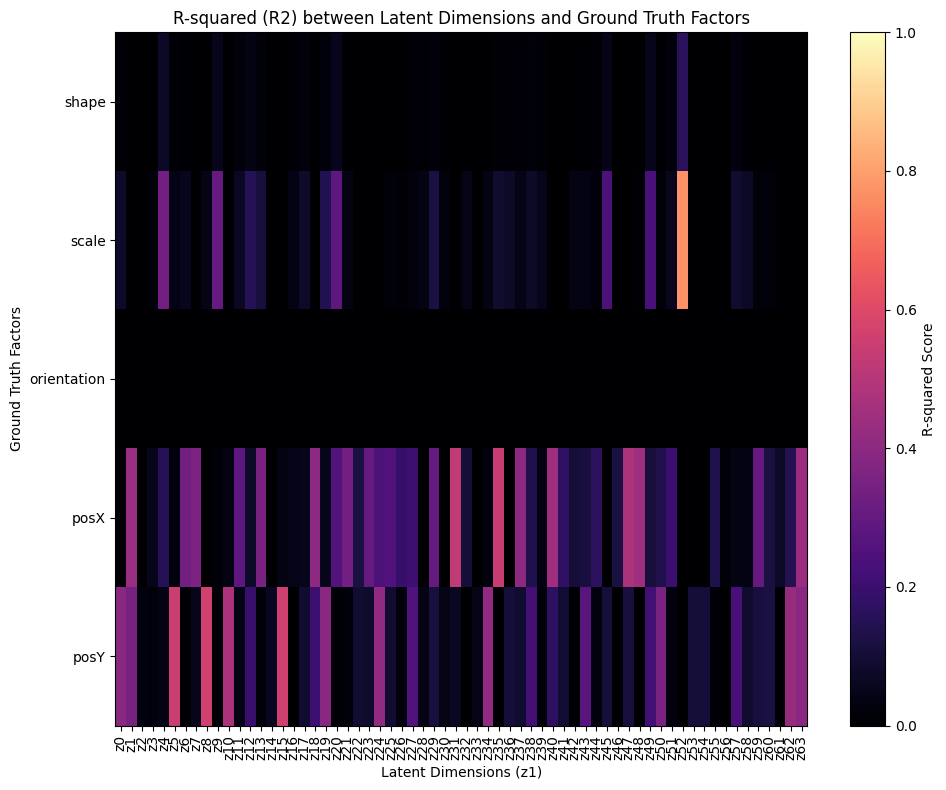

Saved R2 heatmap to ./metrics_hdvae/linear_r2_heatmap.png

Calculating DCI (Disentanglement, Completeness, Informativeness) Score...
Discretizing ground truth factors into 10 bins for DCI...
Training RandomForestClassifiers for each ground truth factor...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


DCI per factor:   0%|          | 0/5 [00:00<?, ?it/s]


DCI Scores:
--------------------------------------------------
  Informativeness: 0.7097
  Disentanglement: 0.0551
  Completeness:    0.0582
--------------------------------------------------

Quantitative Metrics Evaluation Complete

Finished evaluating Beta-VAE.


In [28]:
# beta_vae_model
model=beta_vae_model_
# --- Run Metrics After Training ---
print("\n" + "="*50)
print("Starting Quantitative Metrics Evaluation")
print("="*50 + "\n")

# Define the number of samples for metrics calculation to speed it up.
# For dSprites, 10,000 to 20,000 samples is usually sufficient.
# Set to None to use all available samples in the test_dataset.
NUM_SAMPLES_FOR_METRICS = 20000

# Collect data for metrics (using test_loader, but now limited by NUM_SAMPLES_FOR_METRICS)
# It's good to keep batch_size for the data_loader relatively high (e.g., 256)
# to make efficient use of the GPU during the forward pass.
metrics_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)


######################################


mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx = \
    collect_latent_factors_for_metrics2(model, metrics_data_loader, device,
                                       num_samples_to_collect=NUM_SAMPLES_FOR_METRICS)

# Calculate and print MIG
mig_avg_score, mig_report = calculate_mig(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print Linear Regression Disentanglement Score
linear_disentanglement_avg_score, linear_r2_report, linear_disentanglement_summary = \
    calculate_linear_disentanglement_score(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print DCI
dci_informativeness, dci_disentanglement, dci_completeness, dci_report = \
    calculate_dci(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

print("\n" + "="*50)
print("Quantitative Metrics Evaluation Complete")
print("="*50 + "\n")


#######################
model_name = "Beta-VAE"
model_results = {
    "Model": model_name,
    "MIG Score": mig_avg_score,
    "DCI Informativeness": dci_informativeness,
    "DCI Disentanglement": dci_disentanglement,
    "DCI Completeness": dci_completeness,
    "Average R2 Disentanglement": linear_disentanglement_avg_score,
}
all_model_results.append(model_results)
print(f"Finished evaluating {model_name}.")


In [29]:
# V4: FactorVAE for comparison

# --- FactorVAE Model ---
# FactorVAE aims for disentanglement by adding a Total Correlation (TC) penalty.

class FactorVAE(nn.Module):
    def __init__(self, image_size, z_dim):
        super(FactorVAE, self).__init__()
        self.image_size = image_size
        self.z_dim = z_dim

        # Encoder (identical to Vanilla/Beta VAE)
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_mu = nn.Linear(128, z_dim)
        self.fc_logvar = nn.Linear(128, z_dim)

        # Decoder (identical to Vanilla/Beta VAE)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x.view(-1, self.image_size))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        z = self.reparameterize(mu, log_var)

        # Decode
        recon_x = self.decoder(z)
        return recon_x, mu, log_var, z # Return z for TC calculation

# --- Discriminator for FactorVAE ---
class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super(Discriminator, self).__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
            nn.Linear(z_dim, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 2) # Output logits for binary classification (real vs. permuted)
        )

    def forward(self, z):
        return self.model(z)



# --- FactorVAE Loss Function Components ---
# The loss calculation is more complex and will be handled within the training loop.
# Here's the KL divergence part, standard for VAEs.
def kl_divergence(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())




# --- Setup for FactorVAE Training ---
factor_vae_z_dim = z1_dim # Still 64 for consistency
# Hyperparameter gamma for Total Correlation loss
factor_vae_gamma = 10.0 # Common values range from 1 to 100
# Discriminator training iterations per VAE training iteration
num_discriminator_steps = 1 # Usually 1 or 2

factor_vae_model = FactorVAE(image_size, factor_vae_z_dim).to(device)
discriminator_model = Discriminator(factor_vae_z_dim).to(device)

factor_vae_optimizer = torch.optim.Adam(factor_vae_model.parameters(), lr=learning_rate)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate)

# Binary Cross-Entropy Loss for the discriminator
bce_logits = nn.CrossEntropyLoss() # For D, 2 output logits

print("\n--- FactorVAE Model ---")
print(factor_vae_model)
print("\n--- FactorVAE Discriminator Model ---")
print(discriminator_model)

# --- Training Loop for FactorVAE ---
print(f"\nStarting FactorVAE training with gamma = {factor_vae_gamma}...")
for epoch in range(num_epochs):
    factor_vae_model.train()
    discriminator_model.train()
    total_vae_loss = 0
    total_disc_loss = 0

    for i, (images, _,_) in enumerate(train_loader):
        images = images.to(device)
        batch_size = images.size(0)

        # --- Train Discriminator ---
        for _ in range(num_discriminator_steps):
            discriminator_optimizer.zero_grad()

            recon_images, mu, log_var, z = factor_vae_model(images) # Get z for discriminator

            # Sample z from aggregate posterior q(z) - approximated by current batch z's
            # Create a permuted copy of z
            z_permuted = []
            for _z in z.transpose(0, 1): # Iterate over each latent dimension
                idx = torch.randperm(batch_size) # Random permutation for each dim
                z_permuted.append(_z[idx])
            z_permuted = torch.stack(z_permuted, 1) # Stack back to (batch_size, z_dim)

            # Pass through discriminator
            d_z = discriminator_model(z.detach()) # Detach z from VAE graph
            d_z_permuted = discriminator_model(z_permuted.detach()) # Detach z_permuted

            # Discriminator loss: try to classify real vs. permuted
            # Real samples should be classified as 0, permuted as 1 (or vice-versa depending on setup)
            real_labels = torch.zeros(batch_size).long().to(device) # Label 0 for original
            perm_labels = torch.ones(batch_size).long().to(device)  # Label 1 for permuted

            disc_loss = 0.5 * (bce_logits(d_z, real_labels) + bce_logits(d_z_permuted, perm_labels))

            disc_loss.backward()
            discriminator_optimizer.step()
            total_disc_loss += disc_loss.item()

        # --- Train VAE ---
        factor_vae_optimizer.zero_grad()

        recon_images, mu, log_var, z = factor_vae_model(images)

        # 1. Reconstruction Loss
        recon_loss = F.binary_cross_entropy(recon_images, images.view(-1, image_size), reduction='sum')

        # 2. KL Divergence (Standard VAE KLD)
        kld_loss = kl_divergence(mu, log_var)

        # 3. Total Correlation (TC) Loss
        # This term tries to fool the discriminator into thinking real samples are permuted.
        # It's log(D(z)) - log(1-D(z))
        d_z = discriminator_model(z) # No detach here, we want gradients to flow to VAE

        # Log-probabilities for TC calculation
        # The discriminator outputs 2 logits: [logit_real, logit_permuted]
        # P(z is real) = softmax(d_z)[0], P(z is permuted) = softmax(d_z)[1]
        # We want log(P(z is real) / P(z is permuted))

        # Safe way to compute log(P_real / P_permuted) or similar quantities
        # using log_softmax and then subtraction
        logits_real = d_z[:, 0]
        logits_perm = d_z[:, 1]

        # TC loss is derived from the discriminator's ability to distinguish real from permuted.
        # It's (log(D(z)_real) - log(D(z)_permuted)) for the VAE's loss,
        # encouraging D(z)_real to be small and D(z)_permuted to be large.
        # This is essentially making D(z) predict permuted for real samples.
        tc_loss = (logits_real - logits_perm).mean() # As per FactorVAE paper's interpretation

        # Full VAE Loss
        vae_loss = recon_loss + kld_loss + factor_vae_gamma * tc_loss

        vae_loss.backward()
        factor_vae_optimizer.step()
        total_vae_loss += vae_loss.item()

        if (i+1) % 100 == 0:
            print(f"FactorVAE - Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], VAE Loss: {vae_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

    avg_vae_loss = total_vae_loss / len(train_loader.dataset)
    avg_disc_loss = total_disc_loss / (len(train_loader.dataset) * num_discriminator_steps)

    print(f"FactorVAE - Epoch [{epoch+1}/{num_epochs}] completed. Avg VAE Loss: {avg_vae_loss:.4f}")
print("Training complete!")



--- FactorVAE Model ---
FactorVAE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu): Linear(in_features=128, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4096, bias=True)
    (5): Sigmoid()
  )
)

--- FactorVAE Discriminator Model ---
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): 


Starting Quantitative Metrics Evaluation



Collected 20000 samples for metrics.

Calculating MIG (Mutual Information Gap) Score...
Discretizing latent dimensions into 20 bins for MI calculation...


Discretizing Latents:   0%|          | 0/64 [00:00<?, ?it/s]

Discretizing ground truth factors into 20 bins for MI calculation...


Discretizing Factors:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating MI matrix (this can take a while)...

MIG Score:
--------------------------------------------------
  Average MIG Score: 0.2835
--------------------------------------------------
Mutual Information Heatmap saved to mig_mi_heatmap.png

Calculating Linear Regression Disentanglement Score (R-squared)...


Fitting linear regressors:   0%|          | 0/64 [00:00<?, ?it/s]


Linear Regression R-squared Scores:
--------------------------------------------------
Latent Dim   | shape      scale      orientation posX       posY      
----------------------------------------------------------------------
Latent 0     | 0.0002     0.0022     0.0044     0.0001     0.0148    
Latent 1     | 0.0825     0.3760     0.0001     0.1197     0.0317    
Latent 2     | 0.0321     0.1409     0.0003     0.0244     0.1196    
Latent 3     | 0.0020     0.0203     0.0010     0.1687     0.0932    
Latent 4     | 0.0027     0.0036     0.0001     0.2541     0.0657    
Latent 5     | 0.0003     0.0037     0.0002     0.4430     0.1168    
Latent 6     | 0.0021     0.0271     0.0017     0.0839     0.0065    
Latent 7     | 0.0001     0.0003     0.0018     0.0196     0.1123    
Latent 8     | 0.0004     0.0021     0.0052     0.0141     0.0359    
Latent 9     | 0.0058     0.0140     0.0016     0.1085     0.1387    
Latent 10    | 0.0356     0.1102     0.0026     0.0199     0.0482    


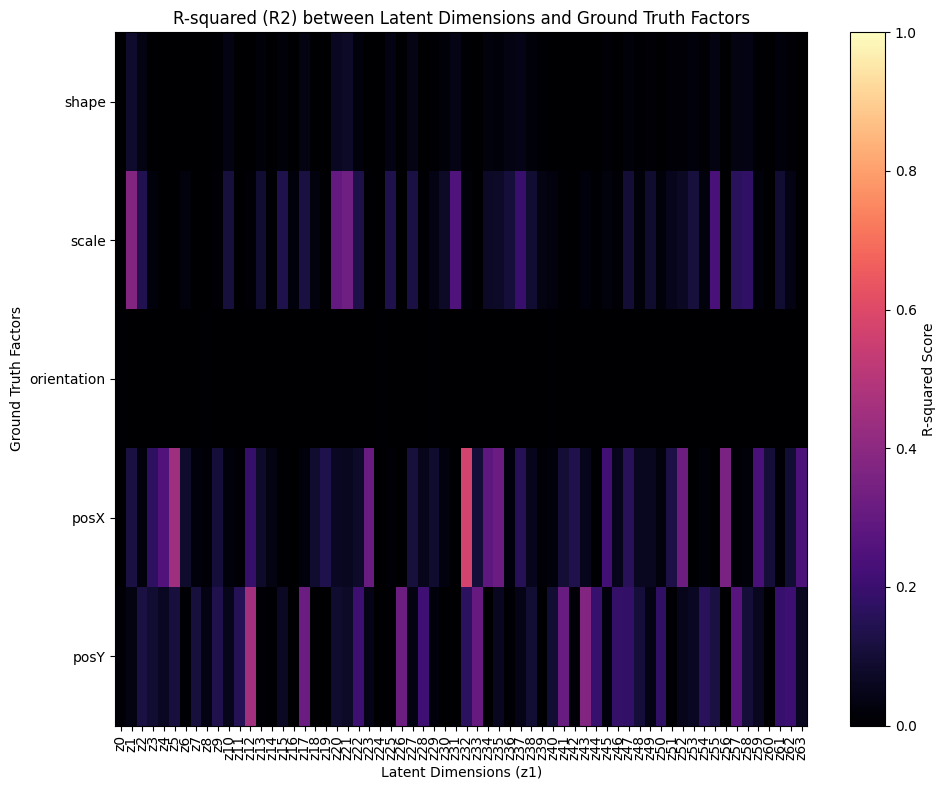

Saved R2 heatmap to ./metrics_hdvae/linear_r2_heatmap.png

Calculating DCI (Disentanglement, Completeness, Informativeness) Score...
Discretizing ground truth factors into 10 bins for DCI...
Training RandomForestClassifiers for each ground truth factor...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


DCI per factor:   0%|          | 0/5 [00:00<?, ?it/s]


DCI Scores:
--------------------------------------------------
  Informativeness: 0.7399
  Disentanglement: 0.0413
  Completeness:    0.0604
--------------------------------------------------

Quantitative Metrics Evaluation Complete

Finished evaluating factor_vae_model.


In [30]:
# beta_vae_model
model=factor_vae_model
# --- Run Metrics After Training ---
print("\n" + "="*50)
print("Starting Quantitative Metrics Evaluation")
print("="*50 + "\n")

# Define the number of samples for metrics calculation to speed it up.
# For dSprites, 10,000 to 20,000 samples is usually sufficient.
# Set to None to use all available samples in the test_dataset.
NUM_SAMPLES_FOR_METRICS = 20000

# Collect data for metrics (using test_loader, but now limited by NUM_SAMPLES_FOR_METRICS)
# It's good to keep batch_size for the data_loader relatively high (e.g., 256)
# to make efficient use of the GPU during the forward pass.
metrics_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)


######################################


mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx = \
    collect_latent_factors_for_metrics2(model, metrics_data_loader, device,
                                       num_samples_to_collect=NUM_SAMPLES_FOR_METRICS)

# Calculate and print MIG
mig_avg_score, mig_report = calculate_mig(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print Linear Regression Disentanglement Score
linear_disentanglement_avg_score, linear_r2_report, linear_disentanglement_summary = \
    calculate_linear_disentanglement_score(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print DCI
dci_informativeness, dci_disentanglement, dci_completeness, dci_report = \
    calculate_dci(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

print("\n" + "="*50)
print("Quantitative Metrics Evaluation Complete")
print("="*50 + "\n")


#######################
model_name = "factor_vae_model"
model_results = {
    "Model": model_name,
    "MIG Score": mig_avg_score,
    "DCI Informativeness": dci_informativeness,
    "DCI Disentanglement": dci_disentanglement,
    "DCI Completeness": dci_completeness,
    "Average R2 Disentanglement": linear_disentanglement_avg_score,
}
all_model_results.append(model_results)
print(f"Finished evaluating {model_name}.")


In [31]:
# V4: DIP-VAE-I (Disentangled Inferred Prior VAE, Type I) for comparison

# --- DIP-VAE-I Model ---
# This model is structurally identical to the Vanilla VAE,
# but its loss function includes a regularization term on the covariance of the latent space.

class DIPVAE(nn.Module):
    def __init__(self, image_size, z_dim):
        super(DIPVAE, self).__init__()
        self.image_size = image_size
        self.z_dim = z_dim

        # Encoder (identical to previous VAEs)
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_mu = nn.Linear(128, z_dim)
        self.fc_logvar = nn.Linear(128, z_dim)

        # Decoder (identical to previous VAEs)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x.view(-1, self.image_size))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        z = self.reparameterize(mu, log_var)

        # Decode
        recon_x = self.decoder(z)
        return recon_x, mu, log_var, z # Return z for DIP-VAE regularization




# --- DIP-VAE-I Loss Function (adapted to calculate covariance within the loop) ---
# The total loss will be calculated in the training loop.

# Function to calculate empirical covariance for a batch of latent vectors
def batch_covariance(z):
    batch_size = z.size(0)
    z_centered = z - z.mean(dim=0, keepdim=True)
    covariance = torch.matmul(z_centered.transpose(0, 1), z_centered) / (batch_size - 1)
    return covariance

# --- Setup for DIP-VAE-I Training ---
dip_vae_z_dim = z1_dim # Still 64 for consistency
# Hyperparameter lambda for DIP-VAE regularization
dip_vae_lambda = 100.0 # Common values range from 1 to 200 for MNIST
# Hyperparameter beta for standard KLD (we'll keep it 1.0 for simplicity, like vanilla)
dip_vae_beta = 1.0

dip_vae_model = DIPVAE(image_size, dip_vae_z_dim).to(device)
dip_vae_optimizer = torch.optim.Adam(dip_vae_model.parameters(), lr=learning_rate)

print("\n--- DIP-VAE-I Model ---")
print(dip_vae_model)

# --- Training Loop for DIP-VAE-I ---
print(f"\nStarting DIP-VAE-I training with lambda = {dip_vae_lambda}...")
for epoch in range(num_epochs):
    dip_vae_model.train()
    total_loss = 0

    for i, (images, _,_) in enumerate(train_loader):
        images = images.to(device)
        batch_size = images.size(0)

        recon_images, mu, log_var, z = dip_vae_model(images) # Get z for regularization

        # 1. Reconstruction Loss
        bce_loss = F.binary_cross_entropy(recon_images, images.view(-1, image_size), reduction='sum')

        # 2. KL Divergence
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 3. DIP-VAE-I Regularization Term
        # Calculate empirical covariance of z for the current batch
        z_cov = batch_covariance(z)

        # Create an identity matrix of size z_dim x z_dim
        identity_matrix = torch.eye(dip_vae_z_dim).to(device)

        # Calculate Frobenius norm squared of (Cov(z) - I)
        dip_loss = torch.norm(z_cov - identity_matrix, p='fro')**2

        # Total Loss
        loss = bce_loss + dip_vae_beta * kld_loss + dip_vae_lambda * dip_loss

        dip_vae_optimizer.zero_grad()
        loss.backward()
        dip_vae_optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"DIP-VAE-I - Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"DIP-VAE-I - Epoch [{epoch+1}/{num_epochs}] completed. Avg Loss: {avg_loss:.4f}")

print("Training complete!")


--- DIP-VAE-I Model ---
DIPVAE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu): Linear(in_features=128, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4096, bias=True)
    (5): Sigmoid()
  )
)

Starting DIP-VAE-I training with lambda = 100.0...
DIP-VAE-I - Epoch [1/10], Step [100/4608], Loss: 65384.8516
DIP-VAE-I - Epoch [1/10], Step [200/4608], Loss: 35245.9805
DIP-VAE-I - Epoch [1/10], Step [300/4608], Loss: 28052.4883
DIP-VAE-I - Epoch [1/10], Step [400/4608], Loss: 23850.9316
DIP-VAE-I - Epoch [1/10], Ste


Starting Quantitative Metrics Evaluation



Collected 20000 samples for metrics.

Calculating MIG (Mutual Information Gap) Score...
Discretizing latent dimensions into 20 bins for MI calculation...


Discretizing Latents:   0%|          | 0/64 [00:00<?, ?it/s]

Discretizing ground truth factors into 20 bins for MI calculation...


Discretizing Factors:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating MI matrix (this can take a while)...

MIG Score:
--------------------------------------------------
  Average MIG Score: 0.1517
--------------------------------------------------
Mutual Information Heatmap saved to mig_mi_heatmap.png

Calculating Linear Regression Disentanglement Score (R-squared)...


Fitting linear regressors:   0%|          | 0/64 [00:00<?, ?it/s]


Linear Regression R-squared Scores:
--------------------------------------------------
Latent Dim   | shape      scale      orientation posX       posY      
----------------------------------------------------------------------
Latent 0     | 0.0077     0.0619     0.0018     0.2846     0.0156    
Latent 1     | 0.0068     0.0339     0.0004     0.1009     0.0522    
Latent 2     | 0.0045     0.0133     0.0001     0.1901     0.0108    
Latent 3     | 0.0101     0.0566     0.0014     0.0153     0.0100    
Latent 4     | 0.0068     0.0418     0.0003     0.0831     0.1664    
Latent 5     | 0.0002     0.0004     0.0000     0.0980     0.2255    
Latent 6     | 0.0001     0.0001     0.0003     0.3854     0.1026    
Latent 7     | 0.0001     0.0007     0.0004     0.2157     0.0008    
Latent 8     | 0.0069     0.0221     0.0016     0.2410     0.0000    
Latent 9     | 0.0139     0.0327     0.0002     0.0603     0.1603    
Latent 10    | 0.0372     0.0990     0.0000     0.0162     0.0010    


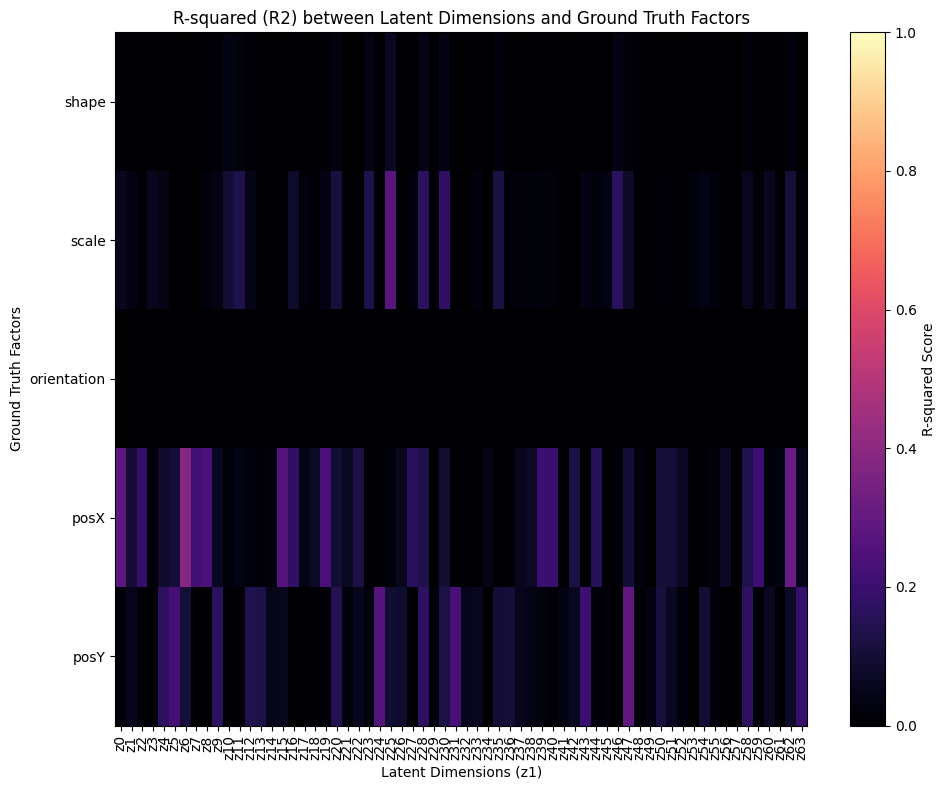

Saved R2 heatmap to ./metrics_hdvae/linear_r2_heatmap.png

Calculating DCI (Disentanglement, Completeness, Informativeness) Score...
Discretizing ground truth factors into 10 bins for DCI...
Training RandomForestClassifiers for each ground truth factor...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


DCI per factor:   0%|          | 0/5 [00:00<?, ?it/s]


DCI Scores:
--------------------------------------------------
  Informativeness: 0.7522
  Disentanglement: 0.0315
  Completeness:    0.0488
--------------------------------------------------

Quantitative Metrics Evaluation Complete

Finished evaluating dip_vae_model.


In [32]:
# beta_vae_model
model=dip_vae_model
# --- Run Metrics After Training ---
print("\n" + "="*50)
print("Starting Quantitative Metrics Evaluation")
print("="*50 + "\n")

# Define the number of samples for metrics calculation to speed it up.
# For dSprites, 10,000 to 20,000 samples is usually sufficient.
# Set to None to use all available samples in the test_dataset.
NUM_SAMPLES_FOR_METRICS = 20000

# Collect data for metrics (using test_loader, but now limited by NUM_SAMPLES_FOR_METRICS)
# It's good to keep batch_size for the data_loader relatively high (e.g., 256)
# to make efficient use of the GPU during the forward pass.
metrics_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)


######################################


mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx = \
    collect_latent_factors_for_metrics2(model, metrics_data_loader, device,
                                       num_samples_to_collect=NUM_SAMPLES_FOR_METRICS)

# Calculate and print MIG
mig_avg_score, mig_report = calculate_mig(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print Linear Regression Disentanglement Score
linear_disentanglement_avg_score, linear_r2_report, linear_disentanglement_summary = \
    calculate_linear_disentanglement_score(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

# Calculate and print DCI
dci_informativeness, dci_disentanglement, dci_completeness, dci_report = \
    calculate_dci(mu1_for_metrics, latents_values_for_metrics, factor_names, active_factors_idx)

print("\n" + "="*50)
print("Quantitative Metrics Evaluation Complete")
print("="*50 + "\n")


#######################
model_name = "dip_vae_model"
model_results = {
    "Model": model_name,
    "MIG Score": mig_avg_score,
    "DCI Informativeness": dci_informativeness,
    "DCI Disentanglement": dci_disentanglement,
    "DCI Completeness": dci_completeness,
    "Average R2 Disentanglement": linear_disentanglement_avg_score,
}
all_model_results.append(model_results)
print(f"Finished evaluating {model_name}.")


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a style for the plots (optional, but makes them look nicer)
sns.set_theme(style="whitegrid")


# Convert to a Pandas DataFrame for easy plotting
df_results = pd.DataFrame(all_model_results)

print("DataFrame of Results:")
print(df_results)


DataFrame of Results:
              Model  MIG Score  DCI Informativeness  DCI Disentanglement  \
0             HDVAE   0.652076              0.61420             0.155516   
1          Beta-VAE   0.318311              0.70965             0.055133   
2  factor_vae_model   0.283476              0.73990             0.041261   
3     dip_vae_model   0.151713              0.75220             0.031496   

   DCI Completeness  Average R2 Disentanglement  
0          0.060963                    0.498342  
1          0.058202                    0.408025  
2          0.060368                    0.299405  
3          0.048808                    0.203182  


<ipython-input-34-0e5ebe9a288f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MIG Score", data=df_results, palette="viridis")


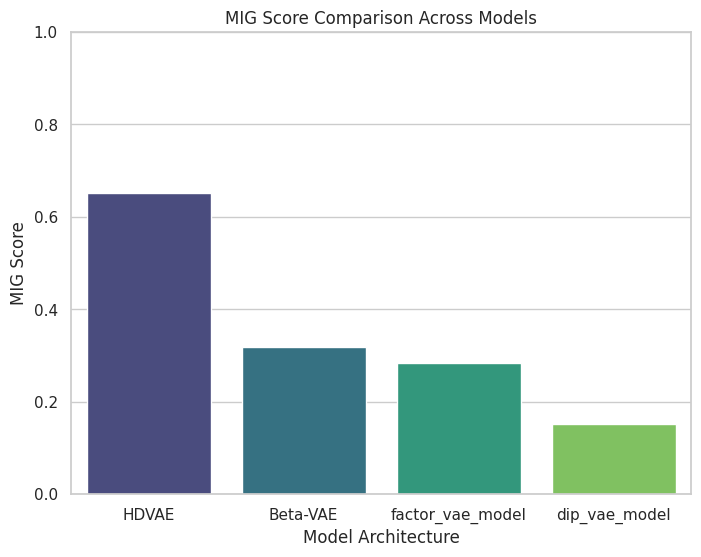

<ipython-input-34-0e5ebe9a288f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Average R2 Disentanglement", data=df_results, palette="magma")


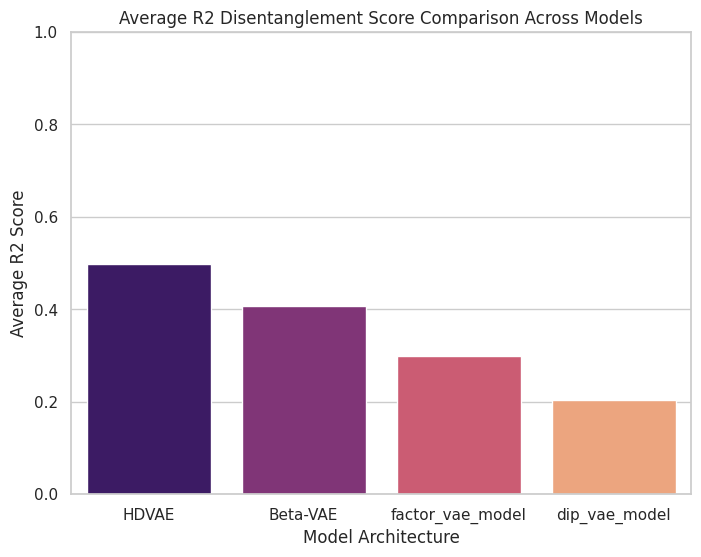

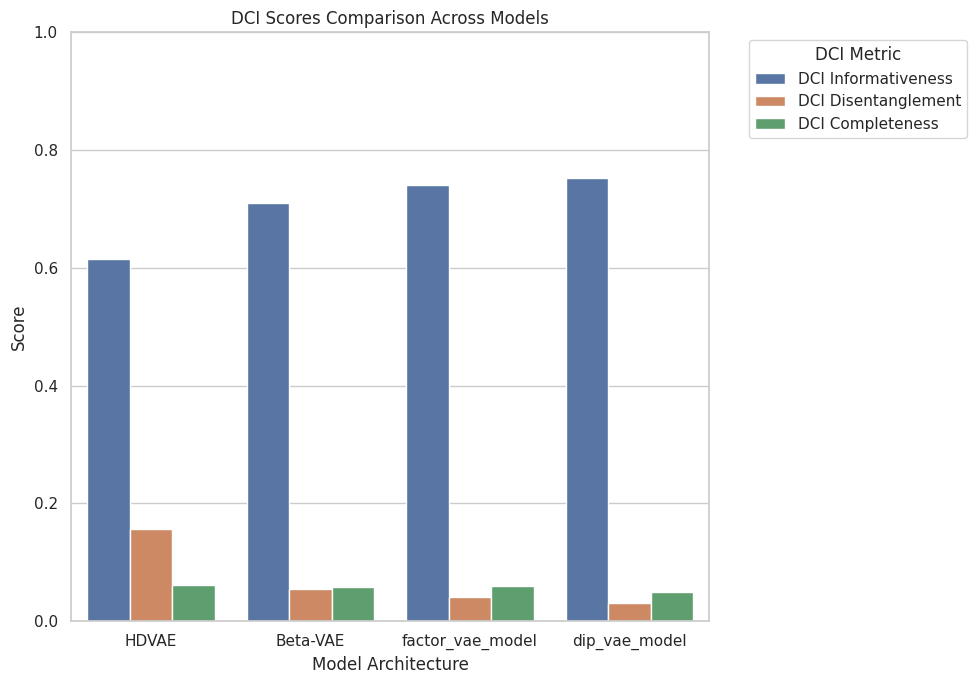

In [34]:

# MIG Score Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="MIG Score", data=df_results, palette="viridis")
plt.title("MIG Score Comparison Across Models")
plt.xlabel("Model Architecture")
plt.ylabel("MIG Score")
plt.ylim(0, 1) # MIG scores are typically between 0 and 1
plt.show()

# Average R2 Disentanglement Score Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Average R2 Disentanglement", data=df_results, palette="magma")
plt.title("Average R2 Disentanglement Score Comparison Across Models")
plt.xlabel("Model Architecture")
plt.ylabel("Average R2 Score")
plt.ylim(0, 1) # R2 scores are typically between 0 and 1
plt.show()

# Plot 3: DCI Scores Comparison (Grouped Bar Chart)
# Melt the DataFrame to long format for DCI plotting
df_dci = df_results[['Model', 'DCI Informativeness', 'DCI Disentanglement', 'DCI Completeness']]
df_dci_melted = df_dci.melt(id_vars='Model', var_name='DCI Metric', value_name='Score')
plt.figure(figsize=(10, 7))
sns.barplot(x="Model", y="Score", hue="DCI Metric", data=df_dci_melted, palette="deep")
plt.title("DCI Scores Comparison Across Models")
plt.xlabel("Model Architecture")
plt.ylabel("Score")
plt.ylim(0, 1) # DCI scores are typically between 0 and 1
plt.legend(title="DCI Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()